# Libraries

In [ ]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as mp
from google.colab import drive
import glob

In [ ]:
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
#!unzip '/content/drive/MyDrive/Colab Notebooks/Enviornment/L6/Imaging Calibs-20240929T165451Z-005.zip' -d '/content/drive/MyDrive/Colab Notebooks/Enviornment/L6/'

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Enviornment/L6/Telescope Data/Imaging Calibs/"

In [ ]:
!ls "/content/drive/MyDrive/Colab Notebooks/Enviornment/L6/Telescope Data/Imaging Calibs"

calibrations_0_001_bias.fit	   calibrations__009_flatOIII20k.fit
calibrations_0_001_dark10.fit	   calibrations__009_flatOIII30k.fit
calibrations_0_001_dark1200.fit    calibrations__009_flatOIII5s.fit
calibrations_0_001_dark300.fit	   calibrations__009_flatOIII6s.fit
calibrations_0_001_dark60.fit	   calibrations__009_flatSI30k.fit
calibrations_0_001_dark900.fit	   calibrations__009_flatSII10k.fit
calibrations_0_002_bias.fit	   calibrations__009_flatSII20k.fit
calibrations_0_002_dark10.fit	   calibrations__009_flatSII5s.fit
calibrations_0_002_dark1200.fit    calibrations__009_flatSII6s.fit
calibrations_0_002_dark300.fit	   calibrations__010_flatHa10k.fit
calibrations_0_002_dark60.fit	   calibrations__010_flatHa20k.fit
calibrations_0_002_dark900.fit	   calibrations__010_flatHa30k.fit
calibrations_0_003_bias.fit	   calibrations__010_flatHa5s.fit
calibrations_0_003_dark10.fit	   calibrations__010_flatHa6s.fit
calibrations_0_003_dark1200.fit    calibrations__010_flatOIII10k.fit
calibrations_

# Code

In [ ]:
exptimes = [10, 60, 300, 900, 1200]  # List of exposure times in seconds for dark frames
ccdtemps = [-20, -10, 0, 8]  # List of CCD temperatures in degrees Celsius during observations
ccdtstr = ['minus20', 'minus10', '0', '8']  # Corresponding string labels for CCD temperatures
ccdgain = 0.6  # CCD gain in ADU (analog-to-digital units) per electron (e-), which converts ADU to physical units

Combining Bias Frames: Using -20°C CCD Temperature for Initial Testing

In [ ]:
files = glob.glob(path+'*minus20_00[1-4]_bias*')

In [ ]:
Nfiles = len(files)
print(Nfiles)

4


In [ ]:
hdu = fits.open(files[0])  # Open the first FITS file containing the bias frame data
bias0 = hdu[0].data  # Extract the data (image array) from the first extension of the FITS file
hdu.close()  # Close the FITS file to free resources

ny, nx = np.shape(bias0)  # Get the dimensions of the bias frame (ny: number of rows, nx: number of columns)
median = np.median(bias0)  # Calculate the median value of the entire bias frame
std = np.std(bias0[:,550:3300])  # Calculate the standard deviation for a specific section of the bias frame (columns 550 to 3300)
print(median, std)  # Print the median and standard deviation values for analysis


331.0 19.53002685320389


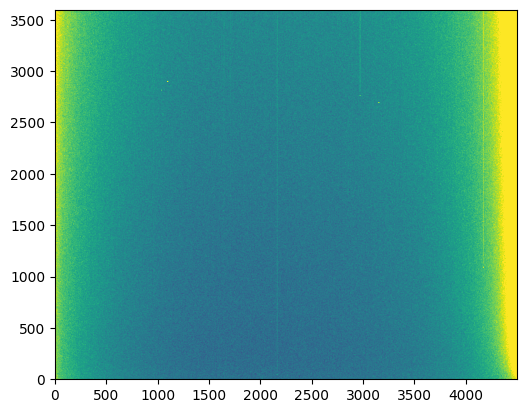

In [ ]:
mp.imshow(bias0, origin='lower', clim=(0.9*median, 1.1*median))  # Display the bias frame using matplotlib with:
# 'origin="lower"' to place the origin at the lower-left corner
# 'clim=(0.9*median, 1.1*median)' to set the display range (color limits) between 90% and 110% of the median value,
# This highlights small variations around the median, making it easier to spot any deviations in the bias frame.

Text(0.5, 0, 'Counts (ADU)')

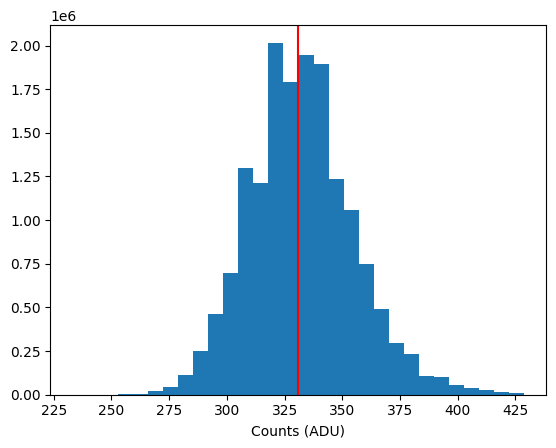

In [ ]:
values = mp.hist(bias0.flatten(), range=(median-5*std, median+5*std), bins=30)
# Create a histogram of the bias frame's pixel values:
# 'bias0.flatten()' flattens the 2D array into 1D for histogram plotting.
# 'range=(median-5*std, median+5*std)' limits the x-axis to ±5 standard deviations around the median.
# 'bins=30' defines the number of bins for the histogram.

mp.axvline(median, color='red')  # Plot a red vertical line at the median value.
mp.xlabel('Counts (ADU)')  # Label the x-axis as 'Counts (ADU)' representing pixel values in ADU.


The bias frame is a calibration image that represents the electronic noise introduced by the camera during image acquisition. Multiple bias frames are typically taken and averaged to create a master bias frame. The master bias is subtracted from science images to remove this noise.

In [ ]:
allbias = np.zeros((Nfiles, ny, nx), dtype=int)  # Initialize an empty array to store all bias frames, with dimensions based on the number of files (Nfiles) and the shape of each frame (ny, nx).

for ind, ff in enumerate(files):
    hdu = fits.open(ff)  # Open each FITS file.
    allbias[ind, ...] = hdu[0].data  # Store the bias frame data into the 'allbias' array at the corresponding index.
    hdu.close()  # Close the FITS file to free resources.

masterbias = np.mean(allbias, axis=0)  # Compute the master bias frame by taking the mean of all the bias frames along the file axis.
del allbias  # Delete the 'allbias' array to free memory, as it's no longer needed.


In [ ]:
print('Median value of MASTERBIAS: {}'.format(np.median(masterbias)))
print('Median value of one BIAS: {}'.format(median))

Median value of MASTERBIAS: 329.5
Median value of one BIAS: 331.0


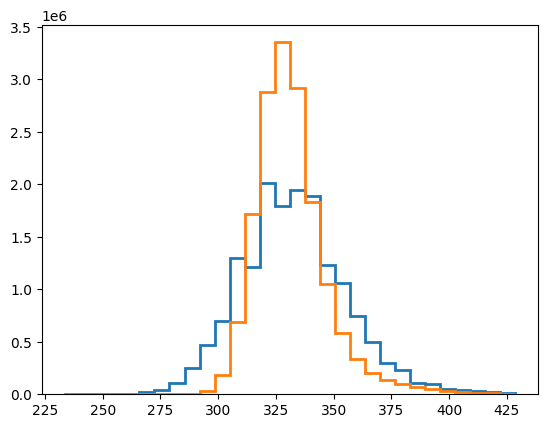

In [ ]:
values = mp.hist(bias0.flatten(), range=(median-5*std, median+5*std), bins=30, lw=2, histtype='step')
values = mp.hist(masterbias.flatten(), range=(median-5*std, median+5*std), bins=30, lw=2, histtype='step')
del bias0

The dark frame is a calibration image that contains both the electronic noise and thermal noise from the camera's sensor when no light is hitting the detector. The goal of this code is to read a dark frame, subtract the master bias frame from it, and then calculate the median and standard deviation of the resulting data.

In [ ]:
files = glob.glob(path+'*minus20_00[1-4]_dark900*')

In [ ]:
Nfiles = len(files)

In [ ]:
dark0 = (fits.open(files[0])[0].data).astype(float)
ny, nx = np.shape(dark0)

dark0 -= masterbias

median = np.median(dark0)
std    = np.std(dark0)

14.0


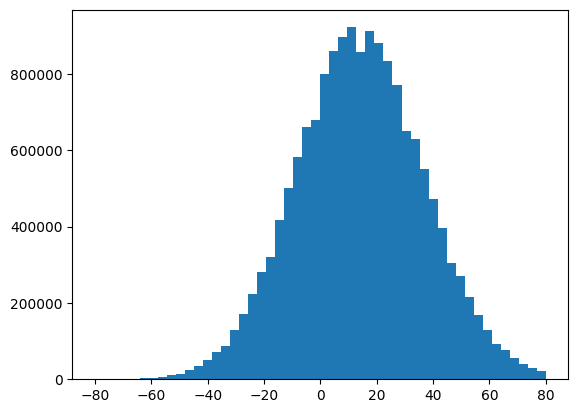

In [ ]:
values = mp.hist(dark0.flatten(), range=(-80, 80), bins=50)
print(median)

In [ ]:
alldark = np.zeros((Nfiles, ny, nx))  # Initialize an empty array to store all dark frames with dimensions (Nfiles, ny, nx).

for ind, ff in enumerate(files):
    hdu = fits.open(ff)  # Open each FITS file containing dark frame data.
    alldark[ind, ...] = hdu[0].data  # Store the dark frame data in the 'alldark' array at the corresponding index.
    hdu.close()  # Close the FITS file to free resources.

masterdark = np.mean(alldark, axis=0)  # Compute the master dark frame by taking the mean of all dark frames along the file axis.
masterdark -= masterbias  # Subtract the master bias from the master dark to remove bias-related noise.
del alldark  # Delete the 'alldark' array to free up memory as it's no longer needed.
del dark0

In [ ]:
values = mp.hist(dark0.flatten(), range=(-80,80), bins=50, lw=2, histtype='step')
values = mp.hist(masterdark.flatten(), range=(-80,80), bins=50, lw=2, histtype='step')

Analyze how the dark current varies with different exposure times and CCD temperatures.
This involves measuring how the longer exposures and higher temperatures contribute to the increase in thermal noise, and investigating the correlation between temperature, exposure time, and the resulting dark current.


In [ ]:
# The function get_dark processes a set of dark and bias frames to compute master frames and analyze their difference.
def get_dark(biaslist, darklist):
    # Initialize an array to store all dark frames.
    alldark = np.zeros((len(darklist), ny, nx))

    # Load and store dark frames from the darklist.
    for ind, ff in enumerate(darklist):
        hdu = fits.open(ff)
        alldark[ind, ...] = hdu[0].data
        hdu.close()

    # Compute the master dark frame by taking the median of all dark frames.
    masterdark = np.median(alldark, axis=0)
    del alldark  # Free memory after processing the dark frames.

    # Initialize an array to store all bias frames.
    allbias = np.zeros((len(biaslist), ny, nx))

    # Load and store bias frames from the biaslist.
    for ind, ff in enumerate(biaslist):
        hdu = fits.open(ff)
        allbias[ind, ...] = hdu[0].data
        hdu.close()

    # Compute the master bias frame by taking the median of all bias frames.
    masterbias = np.median(allbias, axis=0)
    del allbias  # Free memory after processing the bias frames.

    # Return the 16th, 50th, and 84th percentiles of the difference between master dark and master bias frames,
    # along with the master bias and master dark frames for further analysis.
    return np.percentile(masterdark - masterbias, (16, 50, 84)), masterbias, masterdark


In [ ]:
darkcurr = np.zeros((len(exptimes), len(ccdtemps), 3))
# Initialize a 3D array to store the dark current percentiles (16th, 50th, 84th) for each exposure time and CCD temperature.

for time in range(len(exptimes)):
    for temp in range(len(ccdtemps)):
        # Find dark and bias files based on the current temperature and exposure time.
        fdark = glob.glob(path + 'calibrations_{}_00[1-4]_dark{}.fit'.format(ccdtstr[temp], exptimes[time]))
        fbias = glob.glob(path + 'calibrations_{}_00[1-4]_bias.fit'.format(ccdtstr[temp]))

        print(fbias[0], fdark[0])  # Print the first bias and dark frame file names for debugging.
        print('----')

        # Process the dark and bias frames, storing dark current percentiles in darkcurr.
        darkcurr[time, temp, :], masterbias, masterdark = get_dark(fbias, fdark)

        # Optional: Save the master dark and master bias frames as FITS files.
        # hdu = fits.PrimaryHDU(masterdark)
        # hdu.writeto(path+'MASTERDARK_{}_{}.fits'.format(ccdtstr[temp], exptimes[time]), overwrite=True)
        # hdu = fits.PrimaryHDU(masterbias)
        # hdu.writeto(path+'MASTERBIAS_{}.fits'.format(ccdtstr[temp]), overwrite=True)

print(darkcurr[:,1,1])  # Print the 50th percentile dark current values for all exposure times and temperatures.


In [ ]:
colors = ['blue', 'red','green','orange']

# Loop over all CCD temperatures to fit and plot dark current behavior
for temp in range(4):
    # Perform a linear fit (y = mx + c) using exposure times and the 50th percentile of the dark current (e-) at each temperature
    linfit = np.polyfit(exptimes, darkcurr[:, temp, 1] / ccdgain, 1)  # darkcurr[:, temp, 1] selects the 50th percentile

    # Plot the fitted linear function (evaluated using the exposure times) for the current temperature
    mp.plot(exptimes, np.polyval(linfit, exptimes), c=colors[temp])

    # Plot the actual data points (dark current vs. exposure time) as scatter points
    mp.scatter(exptimes, darkcurr[:, temp, 1] / ccdgain, c=colors[temp], label='T = {}'.format(ccdtemps[temp]))

# Label the x-axis as 'Time (s)'
mp.xlabel('Time (s)')

# Label the y-axis as 'Dark Current (e-)'
mp.ylabel('Dark Current (e-)')

# Add a legend to the plot to distinguish between different CCD temperatures
mp.legend()

# Display the plot
mp.show()


